# Udacity Self-Driving Car Nanodegree
--------------


## CarND-Vehicle-Detection
---------------

![a](https://camo.githubusercontent.com/5b9aa393f43d7bb9cc6277140465f5625f2dae7c/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f756461636974792d7364632f6769746875622f736869656c642d6361726e642e737667)

### The goals / steps of this project are the following:

   1. ***Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier***
    
   2. ***Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.***
    
   3. ***Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.***
    
   4. ***Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
    Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.***
    
   5. ***Estimate a bounding box for vehicles detected.***


#### Imports

In [40]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
import time 
from sklearn.svm import LinearSVC
import matplotlib.image as mpimg
#import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.measurements import label

In [2]:
import pickle
%matplotlib inline

In [3]:
from scipy.ndimage.measurements import label
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [4]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
   

--------

### Manual Vehicle Detection

##### Drawing rectangles over an image

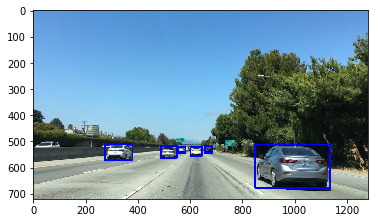

In [5]:
image = mpimg.imread('car.jpg')

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

# Here are the bounding boxes I used
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]


result = draw_boxes(image, bboxes)
plt.imshow(result)

##### Templet Matching

In [6]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function to search for template matches
# and return a list of bounding boxes
def find_matches(img, template_list):
    # Define an empty list to take bbox coords
    bbox_list = []
    # Define matching method
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        # Read in templates one by one
        tmp = mpimg.imread(temp)
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
        # Return the list of bounding boxes
        
    return bbox_list

#### Application over a sample image

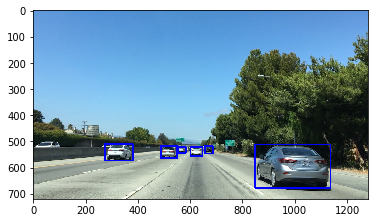

In [7]:
image = mpimg.imread('car.jpg')
#image = mpimg.imread('temp-matching-example-2.jpg')
templist = ['cutouts/cutout1.jpg', 'cutouts/cutout2.jpg', 'cutouts/cutout3.jpg',
            'cutouts/cutout4.jpg', 'cutouts/cutout5.jpg', 'cutouts/cutout6.jpg']
bboxes = find_matches(image, templist)
result = draw_boxes(image, bboxes)
plt.imshow(result)

--------

### Getting familiar with Data

------

In [8]:
# Read in our vehicles and non-vehicles
cars = glob.glob('data/vehicles/**/*.png')
notcars = glob.glob('data/non-vehicles/**/*.png')

In [9]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [10]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


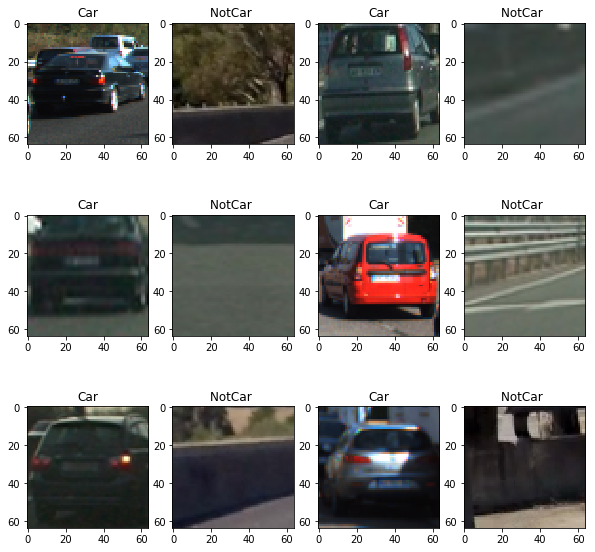

In [11]:
fig = plt.figure(figsize=(10,10))
count = 1
for k in range (12):
    # Generate a random index to look at a car image
    if k%2 ==0:
        ind = np.random.randint(0, len(cars))
        Img = mpimg.imread(cars[ind])
        #fig-1
        fig.add_subplot(3,4,count)
        plt.imshow(Img)
        plt.title('Car')
        count += 1
    else:
        ind = np.random.randint(0, len(notcars))
        Img = mpimg.imread(notcars[ind])
        #fig-1
        fig.add_subplot(3,4,count)
        plt.imshow(Img)
        plt.title('NotCar ')
        count += 1

------

### Feature Extraction

---

In [12]:
class FeatureExtraction(object):
    
    
    def __init__(self,hist_bins,hist_bins_range,spatial_size,\
                 orient,pix_per_cell,cell_per_block):
        
        self.hist_bins = hist_bins # hist_bins=32
        self.hist_bins_range= hist_bins_range # hist_bins_range = (0, 256)
        self.spatial_size=spatial_size # spatial_size=(32, 32)
        self.orient = orient # orient=9
        self.pix_per_cell = pix_per_cell # pix_per_cell=8
        self.cell_per_block = cell_per_block # cell_per_block=2
        
     
    def bin_spatial(self,img):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, self.spatial_size).ravel() 
        # Return the feature vector
        return features
    
    
    def convert_color(self,img, cspace):
        if cspace == 'BGR':
            return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        if cspace == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        if cspace == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        if cspace == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        if cspace == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        if cspace == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
    
    '''Define a function to compute color histogram features ''' 
    
    def color_hist(self,img,plot_info=False):
        # Compute the histogram of the color channels separately
        ch1_hist = np.histogram(img[:,:,0],
                                     bins= self.hist_bins,
                                     range=self.hist_bins_range)
        
        ch2_hist = np.histogram(img[:,:,1],
                                     bins=self.hist_bins,
                                     range=self.hist_bins_range)
        
        ch3_hist = np.histogram(img[:,:,2],
                                     bins=self.hist_bins,
                                     range=self.hist_bins_range)
        bin_edges = ch1_hist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
        
        # Return the individual histograms, bin_centers and feature vector
        if plot_info:
            return  ch1_hist,ch2_hist,ch3_hist, bin_centers, hist_features
        else:
            return hist_features
    
    
        
        
    ''' Define a function to extract features from a list of images
        Have this function call bin_spatial() and color_hist()'''
    
    def extract_color_features(self,imgs, cspace='RGB'):
                      
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for file in imgs:
            # Read in each one by one
            image = mpimg.imread(file)
            # apply color conversion if other than 'RGB'
            if cspace != 'RGB':
                feature_image = self.convert_color(image,cspace)
            else: feature_image = np.copy(image)   
            
            
            # Apply bin_spatial() to get spatial color features
            spatial_features = self.bin_spatial(feature_image)
            
            # Apply color_hist() also with a color space option now
            hist_features = self.color_hist(feature_image)
            
            # Append the new feature vector to the features list
            features.append(np.hstack((spatial_features, hist_features)))
        
        
        # Return list of feature vectors
        return features 
    
    
    def get_hog_features(self,img,vis,feature_vec):
        if vis == True:
            features, hog_image = hog(img,
                                  orientations=self.orient,
                                  pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                  cells_per_block=(self.cell_per_block, self.cell_per_block),
                                  transform_sqrt=False,
                                  visualise=True,
                                  feature_vector=feature_vec)
        
            return features, hog_image
        else:      
            features = hog(img,
                       orientations=self.orient,
                       pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                       cells_per_block=(self.cell_per_block, self.cell_per_block),
                       transform_sqrt=False,
                       visualise=False,
                       feature_vector=feature_vec)
        
            return features 
        
        
        
    ''' Define a function to extract features from a list of images
        Have this function call bin_spatial() and color_hist()'''
    
    def extract_hog_features(self,imgs, cspace='RGB', hog_channel=0):
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for file in imgs:
            # Read in each one by one
            image = mpimg.imread(file)
            # apply color conversion if other than 'RGB'
            if cspace != 'RGB':
                feature_image = self.convert_color(image,cspace)
            else: feature_image = np.copy(image)      

            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(self.get_hog_features(feature_image[:,:,channel],
                                                              vis=False, 
                                                              feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = self.get_hog_features(feature_image[:,:,hog_channel],
                                                     vis=False,
                                                     feature_vec=True)
                
            # Append the new feature vector to the features list
            features.append(hog_features)
        # Return list of feature vectors
        return features

#### Application of some feature extraction techniques

In [13]:
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
hist_bins = 32
hist_bins_range = (0,256)
spatial_size = (32,32)

FE = FeatureExtraction(hist_bins = hist_bins,\
                            hist_bins_range =  hist_bins_range,\
                            spatial_size = spatial_size,\
                            orient = orient,\
                            pix_per_cell =  pix_per_cell,\
                            cell_per_block =  cell_per_block)


#### Exploration of different chanals for hist feature vecture

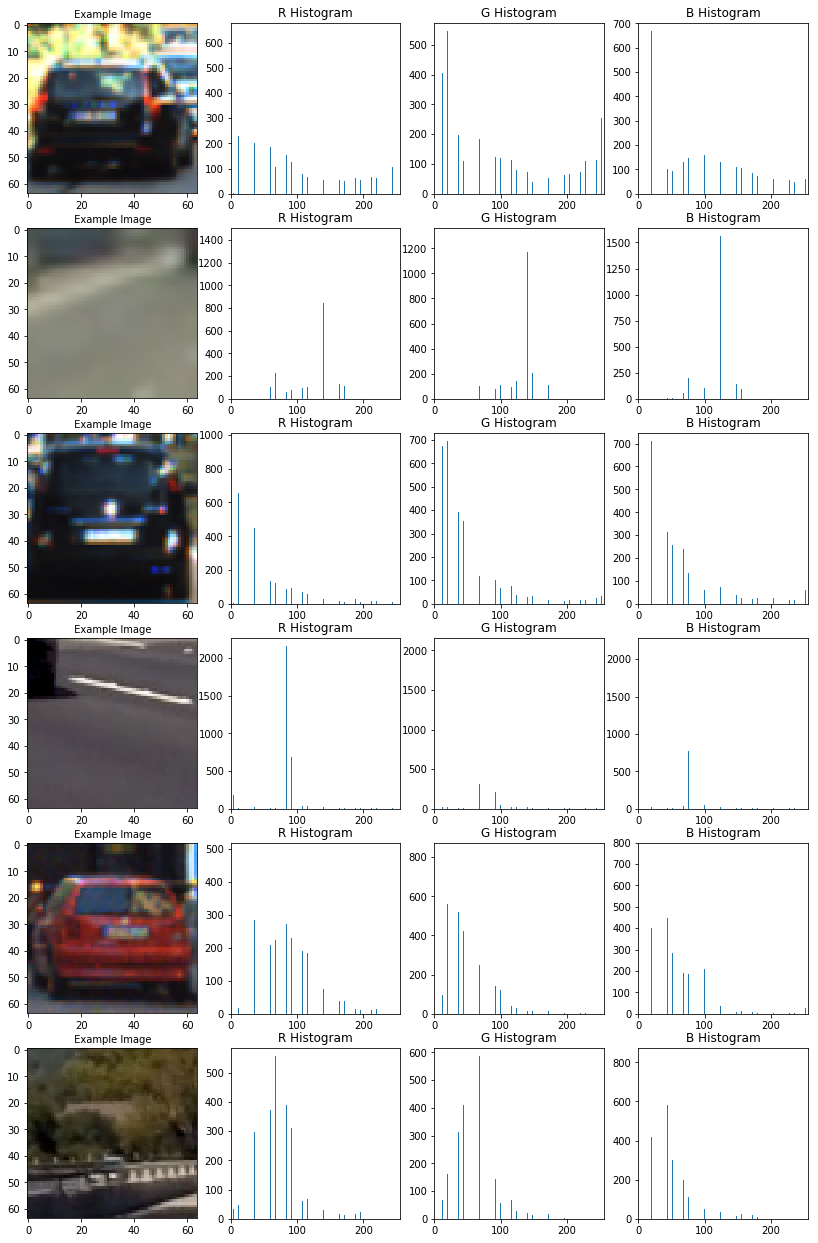

In [14]:
fig = plt.figure(figsize=(14,22))

count = 1
n1,n2 = 6,4
for k in range(6):
    
    if k%2 ==0:
        ind = np.random.randint(0, len(cars))
        Img = cv2.imread(cars[ind])
        
    else:
        ind = np.random.randint(0, len(notcars))
        Img = cv2.imread(notcars[ind])
    
    
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
    
    ch1_hist,ch2_hist,ch3_hist, bincen, hist_features\
         = FE.color_hist(Img,plot_info=True)
    
    
    #fig-1
    fig.add_subplot(n1,n2,count)
    plt.imshow(Img)
    plt.title(' Example Image', fontsize=10)
    count += 1
    
    #fig-2
    fig.add_subplot(n1,n2,count)
    plt.bar(bincen,ch1_hist[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    count += 1
    
    #fig-3
    fig.add_subplot(n1,n2,count)
    plt.bar(bincen,ch2_hist[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    count += 1
    
    #fig-4
    fig.add_subplot(n1,n2,count)
    plt.bar(bincen,ch3_hist[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    count += 1  
      

#### Plot of concateneted hist feature vector

-------

#### Exploring bin_spatial feature vectors

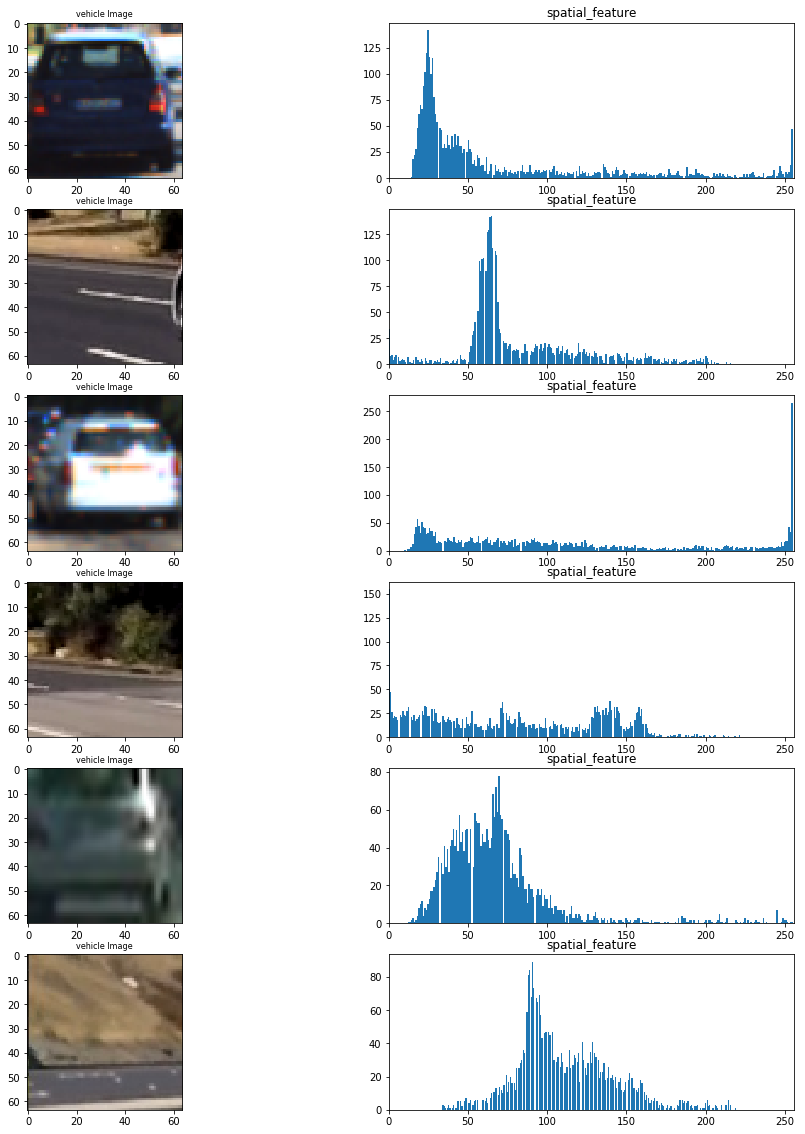

In [15]:
fig = plt.figure(figsize=(16,20))

count = 1
n1,n2 = 6,2
for k in range(6):
    
    if k%2 ==0:
        ind = np.random.randint(0, len(cars))
        Img = cv2.imread(cars[ind])
        
    else:
        ind = np.random.randint(0, len(notcars))
        Img = cv2.imread(notcars[ind])
    
    
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
    
    features = FE.bin_spatial(Img)
    
    
    #fig-1
    fig.add_subplot(n1,n2,count)
    plt.imshow(Img)
    plt.title('vehicle Image', fontsize=8)
    count += 1
    
    
    #fig-5
    fig.add_subplot(6,2,count)
    plt.hist(features,bins=255)
    plt.xlim(0, 256)
    plt.title('spatial_feature')
    count += 1 

------

#### Exploration of color spaces

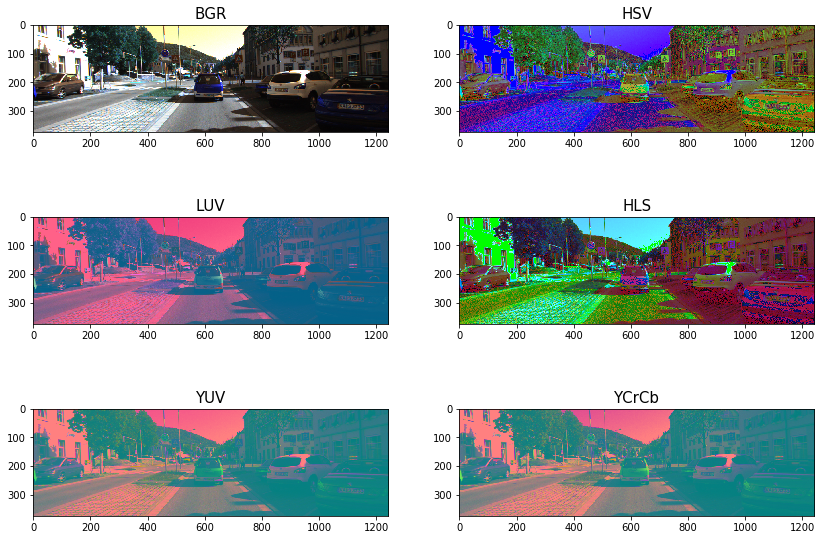

In [16]:
Img = cv2.imread("000275.png")
Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)

count = 1
n1,n2 = 3,2
convs = ['BGR','HSV','LUV','HLS','YUV','YCrCb']

fig = plt.figure(figsize=(14,10))  

for  conv in convs: 
    Img2 = FE.convert_color(Img, conv)
    
    #fig-1
    fig.add_subplot(n1,n2,count)
    plt.imshow(Img2)
    plt.title(conv, fontsize=15)
    count += 1    

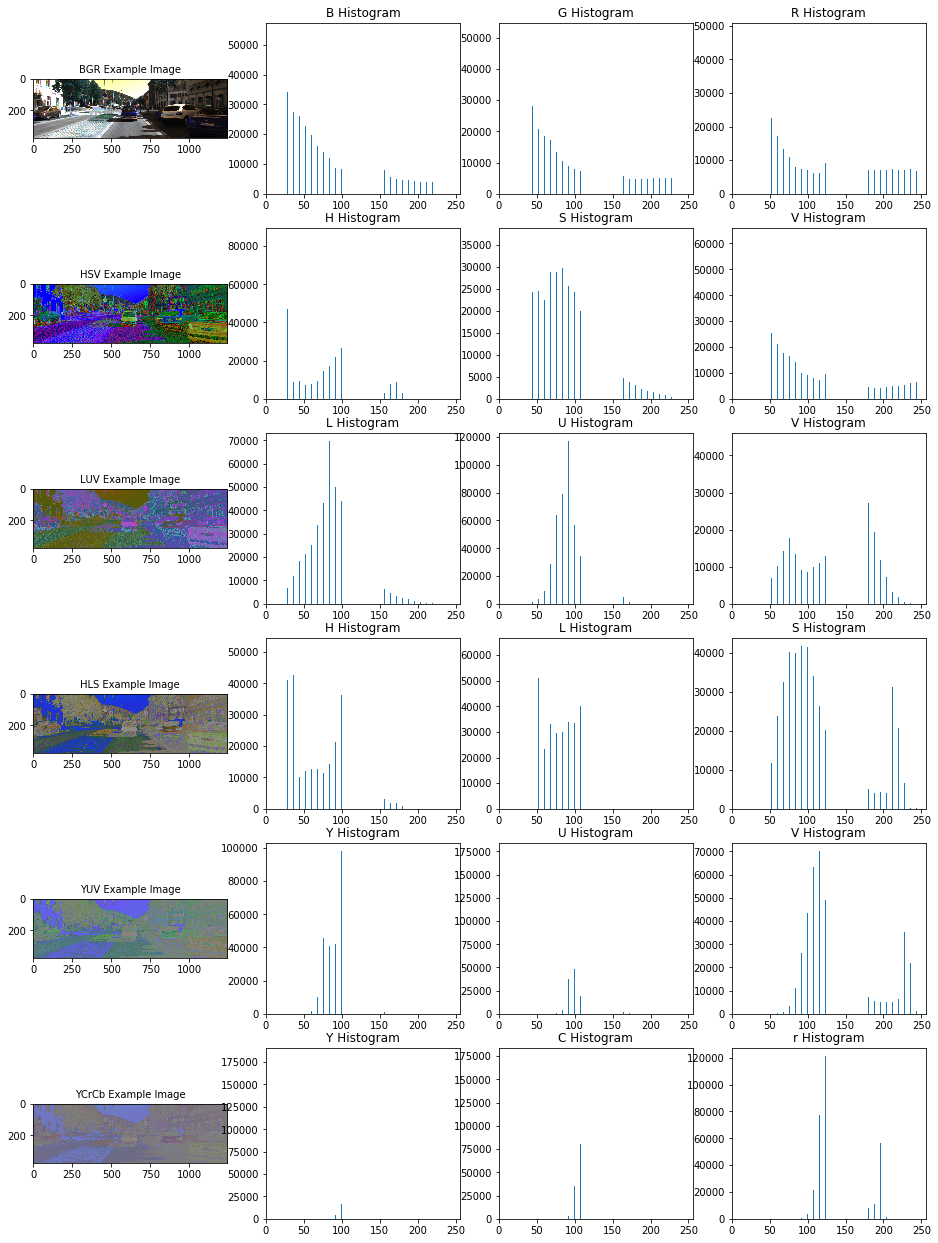

In [17]:
Img = cv2.imread("000275.png")
Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)

count = 1
n1,n2 = 6,4
convs = ['BGR','HSV','LUV','HLS','YUV','YCrCb']

fig = plt.figure(figsize=(16,22))  

for  conv in convs: 
    Img = FE.convert_color(Img, conv)
    
    ch1_hist,ch2_hist,ch3_hist, bincen, hist_features\
         = FE.color_hist(Img,plot_info=True)
    
    #fig-1
    fig.add_subplot(n1,n2,count)
    plt.imshow(Img)
    plt.title(conv+' Example Image', fontsize=10)
    count += 1
    
    #fig-2
    fig.add_subplot(n1,n2,count)
    plt.bar(bincen,ch1_hist[0])
    plt.xlim(0, 256)
    plt.title(conv[0]+' Histogram')
    count += 1
    
    #fig-3
    fig.add_subplot(n1,n2,count)
    plt.bar(bincen,ch2_hist[0])
    plt.xlim(0, 256)
    plt.title(conv[1]+' Histogram')
    count += 1
    
    #fig-4
    fig.add_subplot(n1,n2,count)
    plt.bar(bincen,ch3_hist[0])
    plt.xlim(0, 256)
    plt.title(conv[2]+' Histogram')
    count += 1  
      

---------

#### 3-D plot of color space

In [18]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(6, 6))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

#### Exploring 3D color space

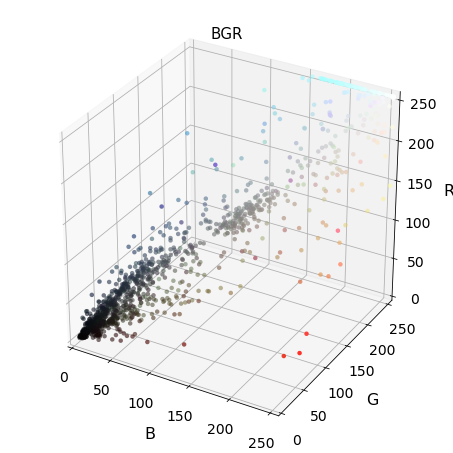

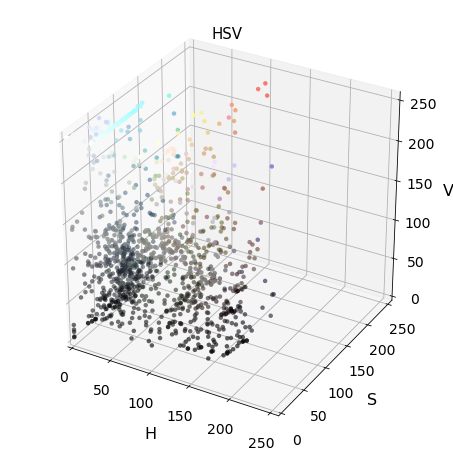

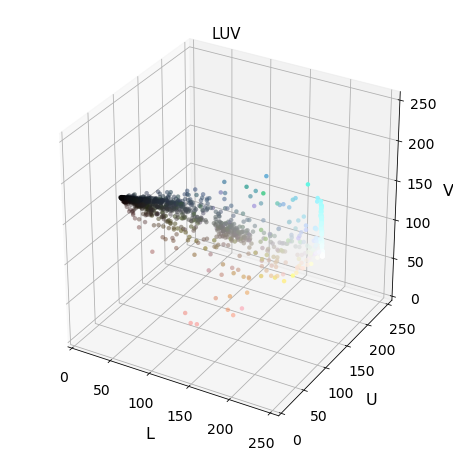

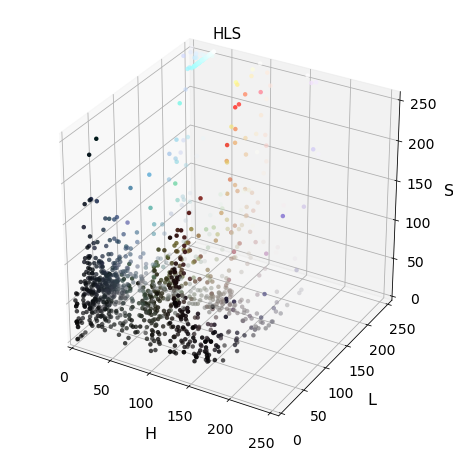

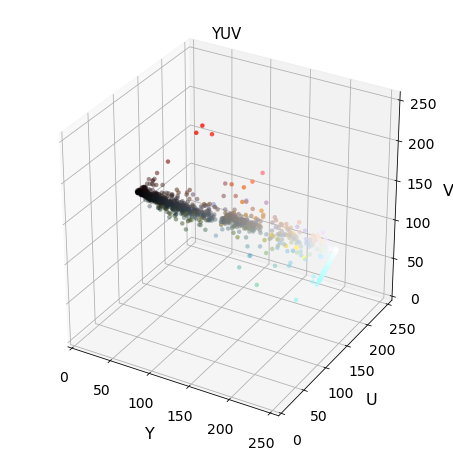

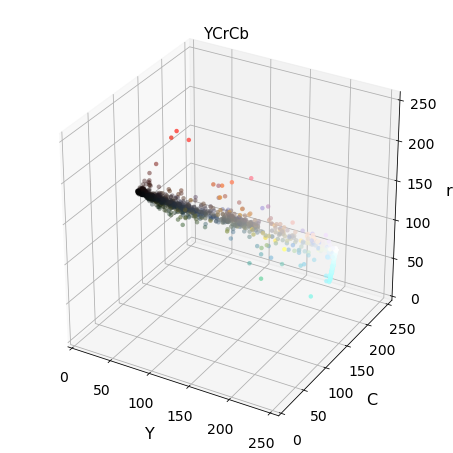

In [19]:
Img = cv2.imread("000275.png")
scale = max(Img.shape[0], Img.shape[1], 64) / 64  # at most 64 rows and columns
Img = cv2.resize(Img, (np.int(Img.shape[1] / scale),\
                             np.int(Img.shape[0] / scale)),\
                             interpolation=cv2.INTER_NEAREST)
    
Img_RGB = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
img_small_rgb = Img_RGB / 255.

convs = ['BGR','HSV','LUV','HLS','YUV','YCrCb']
 
for  conv in convs:
    
    Img2 = FE.convert_color(Img, conv)
    
    #fig-1
    plot3d(Img2, img_small_rgb,axis_labels=list(conv))
    plt.title(conv, fontsize=15)
    plt.show()
    

------

#### Hog feature visualizations

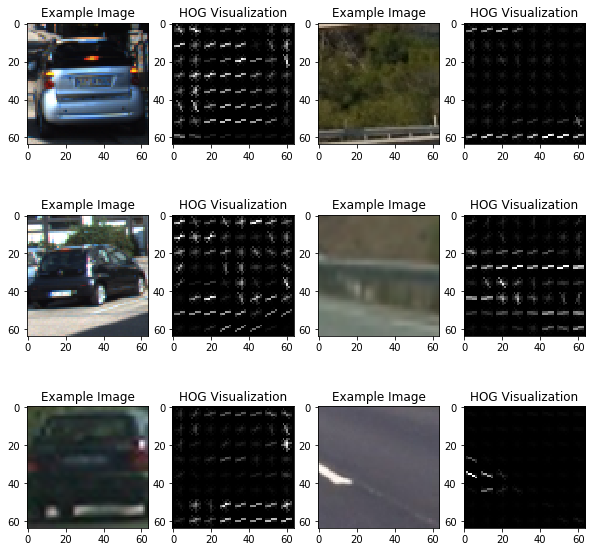

In [20]:
fig = plt.figure(figsize=(10,10))

count = 1
for k in range (6):
    
    # Generate a random index to look at a car image
    if k%2 ==0:
        ind = np.random.randint(0, len(cars))
        Img = mpimg.imread(cars[ind])
    else:
        
        ind = np.random.randint(0, len(notcars))
        Img = mpimg.imread(notcars[ind])
        
    gray = cv2.cvtColor(Img, cv2.COLOR_RGB2GRAY)
    
    features, hog_image = FE.get_hog_features(gray,vis=True, feature_vec=True)
    
    
    #fig-1
    fig.add_subplot(3,4,count)
    plt.imshow(Img)
    plt.title('Example Image')
    count += 1

    
    #fig-1
    fig.add_subplot(3,4,count)
    plt.imshow(hog_image,cmap='gray')
    plt.title('HOG Visualization')
    count += 1
    
   

--------

### Application of feature Normalization

In [21]:
X_car = FE.extract_color_features(cars,cspace=colorspace)
X_notcar = FE.extract_color_features(notcars, cspace=colorspace)
X = np.vstack((X_car,X_notcar)).astype(np.float64) 
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

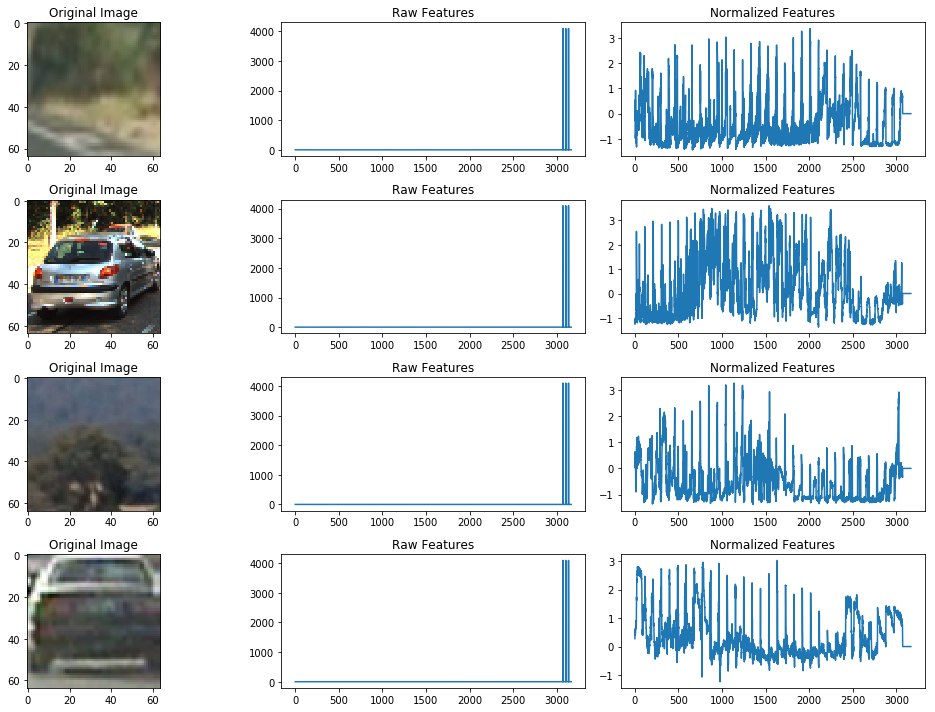

In [22]:
fig = plt.figure(figsize=(14,10))
count = 1
for k in range (1,5):
    # Generate a random index to look at a car image
    if k%2 ==0:
        ind = np.random.randint(0, len(cars))
        Img = mpimg.imread(cars[ind])
        
    else:
        ind = np.random.randint(0, len(notcars))
        Img = mpimg.imread(notcars[ind])
        
    plt.subplot(4,3,count)
    plt.imshow(Img)
    plt.title('Original Image')
    count += 1
        
    plt.subplot(4,3,count)
    plt.plot(X[ind])
    plt.title('Raw Features')
    count += 1
        
    plt.subplot(4,3,count)
    plt.plot(scaled_X[ind])
    plt.title('Normalized Features')
    count += 1
        
    fig.tight_layout()

-------

### Classifier

#### Extraction of all required features

In [23]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]



### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb'  #'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
hist_bins = 32
hist_bins_range = (0,256)
spatial_size = (32,32)




t=time.time()

FE = FeatureExtraction(hist_bins = hist_bins,\
                            hist_bins_range =  hist_bins_range,\
                            spatial_size = spatial_size,\
                            orient = orient,\
                            pix_per_cell =  pix_per_cell,\
                            cell_per_block =  cell_per_block)


color_car_features = FE.extract_color_features(cars,
                                               cspace=colorspace)
color_notcar_features = FE.extract_color_features(notcars,
                                                cspace=colorspace)

hog_car_features = FE.extract_hog_features(cars,
                                    cspace=colorspace,
                                    hog_channel=hog_channel)

hog_notcar_features = FE.extract_hog_features(notcars,
                                       cspace=colorspace,
                                       hog_channel=hog_channel)

t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract HOG features...')


232.56 Seconds to extract HOG features...


#### Stacking all feature to single vector

In [24]:
# Create an array stack of feature vectors
X_car = np.hstack((color_car_features,hog_car_features)).astype(np.float64)
X_notcar = np.hstack((color_notcar_features, hog_notcar_features)).astype(np.float64) 
X = np.vstack((X_car,X_notcar)).astype(np.float64) 

X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(hog_car_features)), np.zeros(len(hog_notcar_features))))

#### Train and test split

In [25]:
from sklearn.utils import shuffle

scaled_X, y = shuffle(scaled_X, y )

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


#### Training Linear SVC

In [26]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC


t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

392.39 Seconds to train SVC...
Test Accuracy of SVC =  0.9904
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  0.  1.  0.]
2.42908 Seconds to predict 10 labels with SVC


#### Saving model for later use

In [27]:
import pickle as pickle
dist_pickle = {}
dist_pickle["svc"] = svc 
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient 
dist_pickle["pix_per_cell"]= pix_per_cell 
dist_pickle["cell_per_block"]= cell_per_block 
dist_pickle["spatial_size"]= spatial_size 
dist_pickle["hist_bins"]= hist_bins 

with open('svc_pickle.p', mode='wb') as f:
    pickle.dump(dist_pickle, f)

------

##### Applying classifier to an image

In [28]:
def find_cars(img, ystart, ystop, scale, svc,\
              X_scaler, color_space, orient,\
              pix_per_cell, cell_per_block,\
              hog_channel,spatial_size, hist_bins):
    
    
   

    FE = FeatureExtraction(hist_bins = hist_bins,\
                            hist_bins_range =  hist_bins_range,\
                            spatial_size = spatial_size,\
                            orient = orient,\
                            pix_per_cell =  pix_per_cell,\
                            cell_per_block =  cell_per_block)

    
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = FE.convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,\
                        (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = FE.get_hog_features(ch1,vis = False, feature_vec=False)
        hog2 = FE.get_hog_features(ch2,vis = False, feature_vec=False)
        hog3 = FE.get_hog_features(ch3,vis = False, feature_vec=False)
    else:
        hog1 = FE.get_hog_features(hog_channel,vis =False, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch

            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos + nblocks_per_window,\
                                 xpos:xpos + nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window,\
                                 xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window,\
                                 xpos:xpos + nblocks_per_window].ravel()
                
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog1[ypos:ypos + nblocks_per_window,\
                                    xpos:xpos + nblocks_per_window].ravel()

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop +\
                                window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = FE.bin_spatial(subimg)
            hist_features = FE.color_hist(subimg)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)

    return draw_img

--------

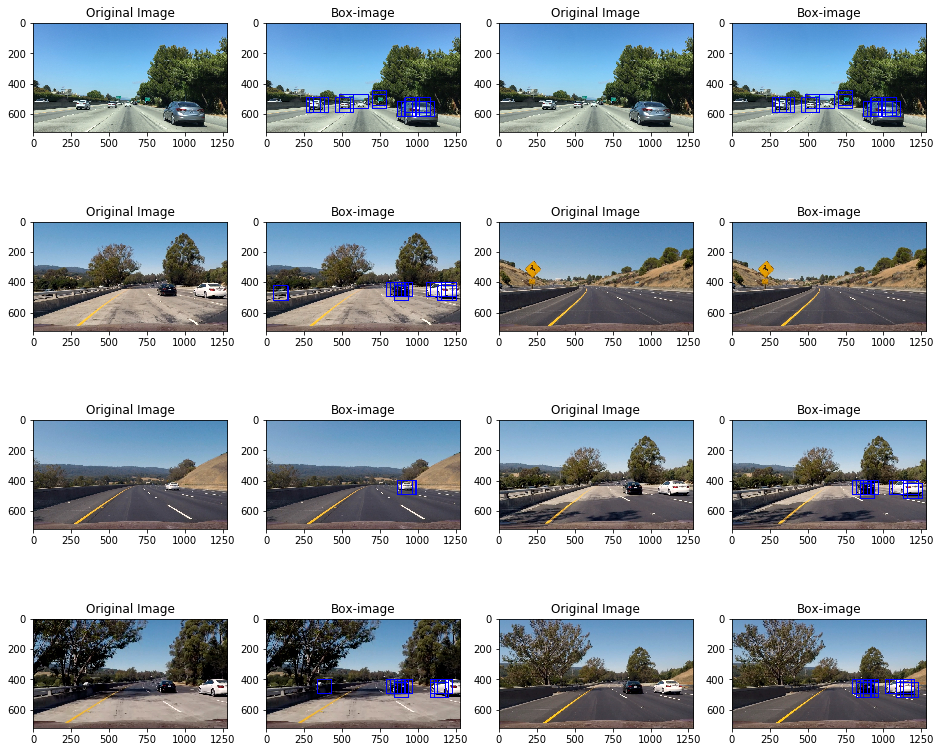

In [29]:
directory = 'test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(16,14))

n1 = 4
n2 = 4
color_space='YCrCb'
ystart = 400
ystop = 656
scale = 1.5

count = 1
for k,img in enumerate(globDir):
    Img = mpimg.imread(img)
    
    out_img = find_cars(Img, ystart, ystop, scale,\
                    svc, X_scaler, color_space,\
                    orient, pix_per_cell, cell_per_block,\
                    hog_channel, spatial_size, hist_bins)
    
    #fig-1
    fig.add_subplot(n1,n2,count)
    plt.imshow(Img)
    plt.title('Original Image')
    count += 1

    
     #fig-2
    fig.add_subplot(n1,n2,count)
    plt.imshow(out_img)
    plt.title('Box-image')
    count += 1
    

### Utilities

#### Sliding window

In [29]:
def slide_window(img, x_start_stop=[None, None],\
                      y_start_stop=[None, None],\
                      xy_window=(64, 64),\
                      xy_overlap=(0.5, 0.5)):
    
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


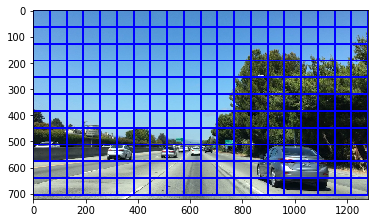

In [30]:
image = mpimg.imread('car.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

---------

##### Multi scale window

In [32]:
def draw_multi_scale_windows(img, ystart, ystop, scale):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    imshape = img_tosearch.shape
    
    img_tosearch = cv2.resize(img_tosearch,\
                              (np.int(imshape[1] / scale),\
                               np.int(imshape[0] / scale)))

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2

    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    rect_start = None
    rect_end = None
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            xbox_left = np.int(xleft * scale)
            ytop_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)
            rect_start = (xbox_left, ytop_draw + ystart)
            rect_end = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
            cv2.rectangle(draw_img, rect_start, rect_end, (0, 0, 255), 6)
    
    cv2.rectangle(draw_img, rect_start, rect_end, (255, 0, 0), 6)

    return draw_img



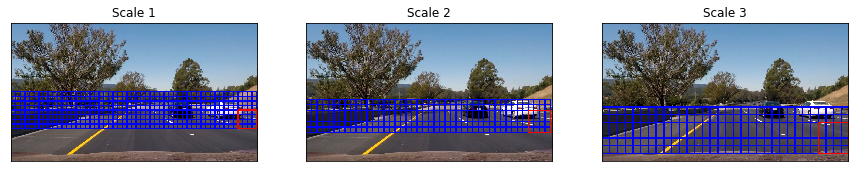

In [33]:
img = mpimg.imread('test_images/test6.jpg')

plt.figure(figsize=(15,10))
subpltcount=1
for (ystart, ystop, scale) in [(360, 560, 1.5), (400, 600, 1.8), (440, 700, 2.5)]:
    
    plt.subplot(1,3,subpltcount)
    plt.imshow(draw_multi_scale_windows(img, ystart, ystop, scale))
    plt.title('Scale %s'%subpltcount)
    plt.xticks([])
    plt.yticks([])
    subpltcount +=1

----------

### Vehicle Detecton Pipeline

---------

In [34]:
class DetectVehicle(object):


    def __init__(self,param_dict):
        self.param_dict = param_dict
        self.svc = self.param_dict['svc'] 
        self.X_scalar = self.param_dict['X_scalar']
        self.orient = self.param_dict['orient']
        self.pix_per_cell = self.param_dict['pix_per_cell'] 
        self.cell_per_block = self.param_dict['cell_per_block']
        self.hist_bins = self.param_dict['hist_bins'] 
        self.spatial_size = self.param_dict['spatial_size'] 
    
    
        self.FE = FeatureExtraction(hist_bins = self.hist_bins,\
                            hist_bins_range =  (0,256),\
                            spatial_size = self.spatial_size,\
                            orient = self.orient,\
                            pix_per_cell =  self.pix_per_cell,\
                            cell_per_block =  self.cell_per_block)
        
        
        self.threshold = 1.0
        self.heatmap = None
        
        # Heat Image for the Last Three Frames
        self.heat_images = deque(maxlen=3)
        
        # Current Frame Count
        self.frame_count = 0
        self.full_frame_processing_interval = 4
        
        # Xstart
        self.xstart = 600
        
        
        # Various Scales
        self.ystart_ystop_scale = [(360, 560, 1.5), (400, 600, 1.8), (440, 700, 2.5)]
        

        # Kernal For Dilation
        self.kernel = np.ones((50, 50))
        
        self.image = None
        
        
    
    def find_cars(self,image,vid=True,vis=False):
        self.image = image
        box_list = []
        draw_img = np.copy(self.image)
        img = self.image.astype(np.float32)/255
        
        if vid: # video
            
            if self.frame_count % self.full_frame_processing_interval == 0:
                mask = np.ones_like(img[:, :, 0])
            else:
                mask = np.sum(np.array(self.heat_images), axis=0)
                mask[(mask > 0)] = 1
                mask = cv2.dilate(mask, self.kernel, iterations=1)

            self.frame_count += 1

            for (self.ystart, self.ystop, self.scale) in self.ystart_ystop_scale:

                nonzero = mask.nonzero()
                nonzeroy = np.array(nonzero[0])
                nonzerox = np.array(nonzero[1])

                if len(nonzeroy) != 0:
                    self.ystart = max(np.min(nonzeroy), self.ystart)
                    self.ystop = min(np.max(nonzeroy), self.ystop)
                if len(nonzeroy) != 0:
                    x_start = max(np.min(nonzerox), self.xstart)
                    x_stop = np.max(nonzerox)
                else:
                    continue

                if x_stop <= x_start or self.ystop <= self.ystart:
                    continue
                    
                ibox_list = self.window_search(img)  
                for k in range(len(ibox_list)):
                    box_list.append(ibox_list[k])
                    
            # Add heat to each box in box list
            self.add_heat_and_threshold(draw_img, box_list)
            # Find final boxes from heatmap using label function
            labels = label(self.heatmap)
            draw_img = self.draw_labeled_bboxes(draw_img, labels)  
            
            return draw_img
         
                    
        else: # picture
            
            for (self.ystart, self.ystop, self.scale) in self.ystart_ystop_scale:
                ibox_list = self.window_search(img)  
                
                for k in range(len(ibox_list)):
                    box_list.append(ibox_list[k])
            
            if vis: # visualize picture with all boaxes found
                return box_list
                
            else: # visualize only threshold boxes  
                draw_image = self.window_search(img)
                # Add heat to each box in box list
                self.add_heat_and_threshold(draw_img, box_list)
                # Find final boxes from heatmap using label function
                labels = label(self.heatmap)
                draw_img = self.draw_labeled_bboxes(draw_img, labels)  
            
                return [draw_img,self.heatmap] 
            
       
        
        
        
    def window_search(self,img):
        
            box_list = []
            img_tosearch = img[self.ystart:self.ystop,:,:]
            ctrans_tosearch = FE.convert_color(img_tosearch, cspace='YCrCb')
    
            if self.scale != 1:
                imshape = ctrans_tosearch.shape
                ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                     (np.int(imshape[1]/self.scale),
                                      np.int(imshape[0]/self.scale)))
        
            ch1 = ctrans_tosearch[:,:,0]
            ch2 = ctrans_tosearch[:,:,1]
            ch3 = ctrans_tosearch[:,:,2]

    
            # Define blocks and steps as above
            nxblocks = (ch1.shape[1] // self.pix_per_cell) - self.cell_per_block + 1
            nyblocks = (ch1.shape[0] // self.pix_per_cell) - self.cell_per_block + 1 
            nfeat_per_block = self.orient*self.cell_per_block**2
    
            # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
            window = 64
            nblocks_per_window = (window // self.pix_per_cell) - self.cell_per_block + 1
            cells_per_step = 2  # Instead of overlap, define how many cells to step
            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
            # Compute individual channel HOG features for the entire image

            hog1 = FE.get_hog_features(ch1,vis=False,feature_vec = False)
            hog2 = FE.get_hog_features(ch2,vis=False,feature_vec = False)
            hog3 = FE.get_hog_features(ch3,vis=False,feature_vec = False)

    
            for xb in range(nxsteps):
                for yb in range(nysteps):
                    ypos = yb*cells_per_step
                    xpos = xb*cells_per_step
                    # Extract HOG for this patch
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window,
                             xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window,
                             xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window,
                             xpos:xpos+nblocks_per_window].ravel() 
            
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                    xleft = xpos*self.pix_per_cell
                    ytop = ypos*self.pix_per_cell

                    # Extract the image patch
                    subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,\
                                                    xleft:xleft+window], (64,64))
        
                    # Get color features
                    spatial_features = self.FE.bin_spatial(subimg)
                    hist_features = self.FE.color_hist(subimg)
            
                    color_features = np.hstack((spatial_features, hist_features))
            
                    X = np.hstack((color_features,hog_features)).reshape(1, -1)
            
                    test_features = X_scaler.transform(X) 
               
                    test_prediction = self.svc.predict(test_features)
            
            
                    if test_prediction == 1:
                    
                        xbox_left = np.int(xleft*self.scale)
                        ytop_draw = np.int(ytop*self.scale)
                        win_draw = np.int(window*self.scale)
                    
                        box_list.append(((xbox_left, ytop_draw + self.ystart),\
                                     (xbox_left + win_draw, ytop_draw + \
                                      win_draw + self.ystart)))
                        
                        
           
            return box_list
            
        
        
       
    
    def add_heat_and_threshold(self,draw_img, bbox_list):
        # Iterate through list of bboxes
        h_map = np.zeros_like(draw_img[:,:,0]).astype(np.float)
        
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            h_map[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            
        self.heat_images.append(h_map)
        self.heatmap = np.sum(np.array(self.heat_images),axis=0)
        # Return thresholded map
        self.heatmap[self.heatmap <= self.threshold] = 0
        # Return updated heatmap
        return 



    def draw_labeled_bboxes(self,img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)),\
                    (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img
    
    
    

##### Application of sliding window search

##### Parameter setting

In [35]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
param_dict = {}

param_dict['ystart']  = 400
param_dict['ystop']  = 656
param_dict['scale'] = 1.5
param_dict['svc']  =  dist_pickle["svc"]
param_dict['X_scalar'] = dist_pickle["scaler"]
param_dict['orient'] = dist_pickle["orient"]
param_dict['pix_per_cell'] = dist_pickle["pix_per_cell"]
param_dict['cell_per_block']  = dist_pickle["cell_per_block"]
param_dict['spatial_size'] = (32,32)
param_dict['hist_bins'] = 32

--------

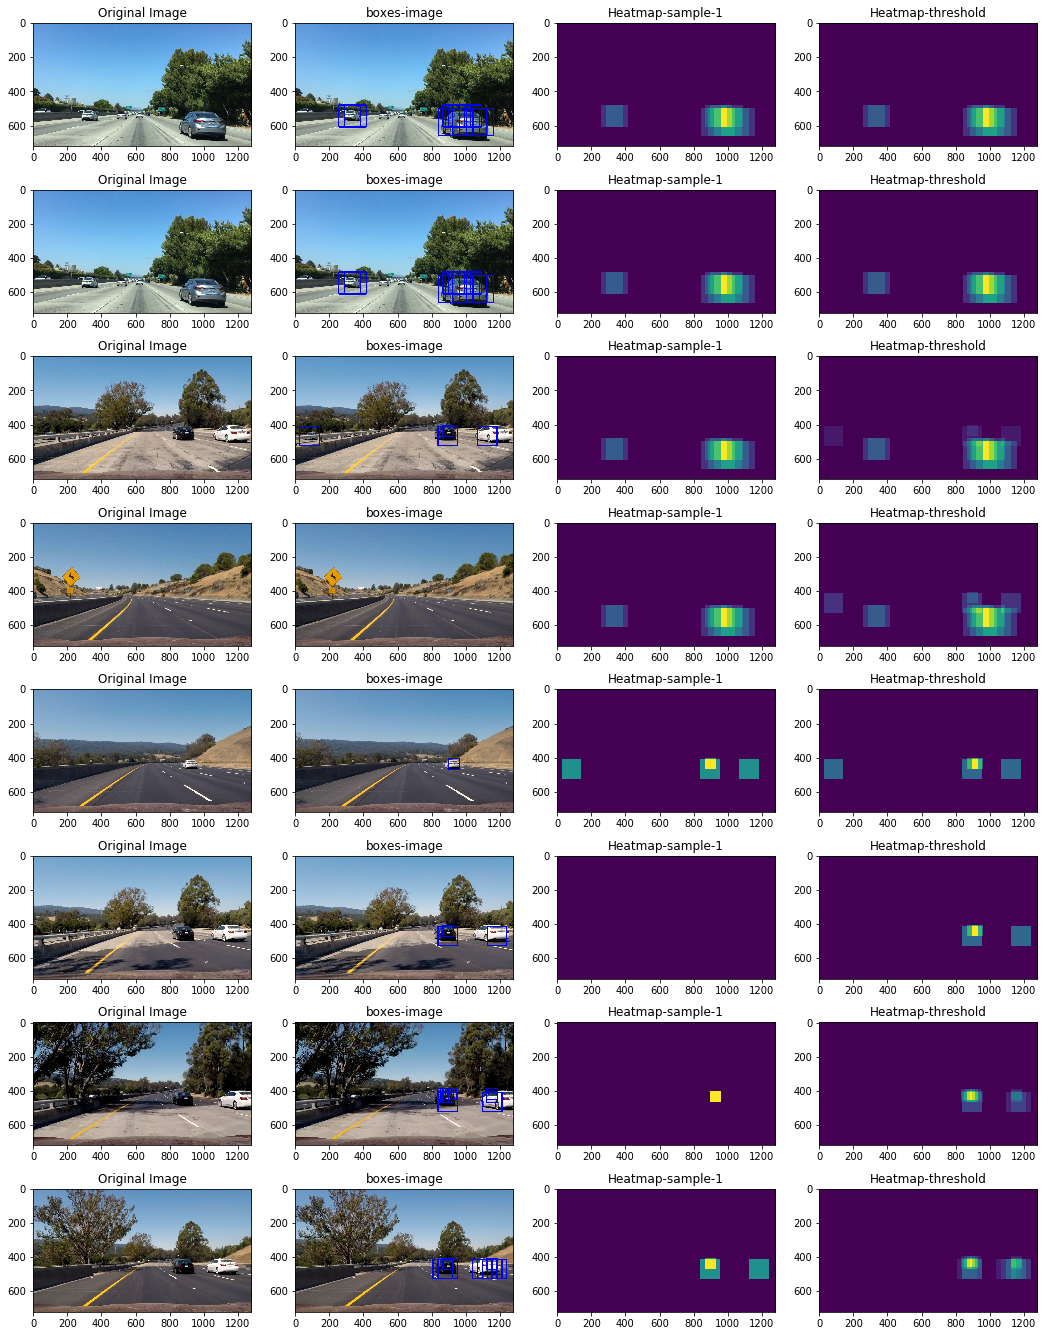

In [35]:
directory = 'test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(18,24))
DV = DetectVehicle(param_dict)
n1 = 8
n2 = 4

count = 1
for k,img in enumerate(globDir):
    Img = mpimg.imread(img)
    boxes = DV.find_cars(Img,vid=False,vis=True)
    [draw_img_,heatmap] = DV.find_cars(Img,vid=False,vis=False)
    
    #fig-1
    fig.add_subplot(n1,n2,count)
    plt.imshow(Img)
    plt.title('Original Image')
    count += 1
   
    #fig-2
    fig.add_subplot(n1,n2,count)
    box_Img = draw_boxes(Img, boxes)
    plt.imshow(box_Img)
    plt.title('boxes-image')
    count += 1

    #fig-3
    fig.add_subplot(n1,n2,count)
    plt.imshow(DV.heat_images[0])
    plt.title('Heatmap-sample-1')
    count += 1
  
    
     #fig-5
    fig.add_subplot(n1,n2,count)
    plt.imshow(DV.heatmap)
    plt.title('Heatmap-threshold')
    count += 1
    
   

-------

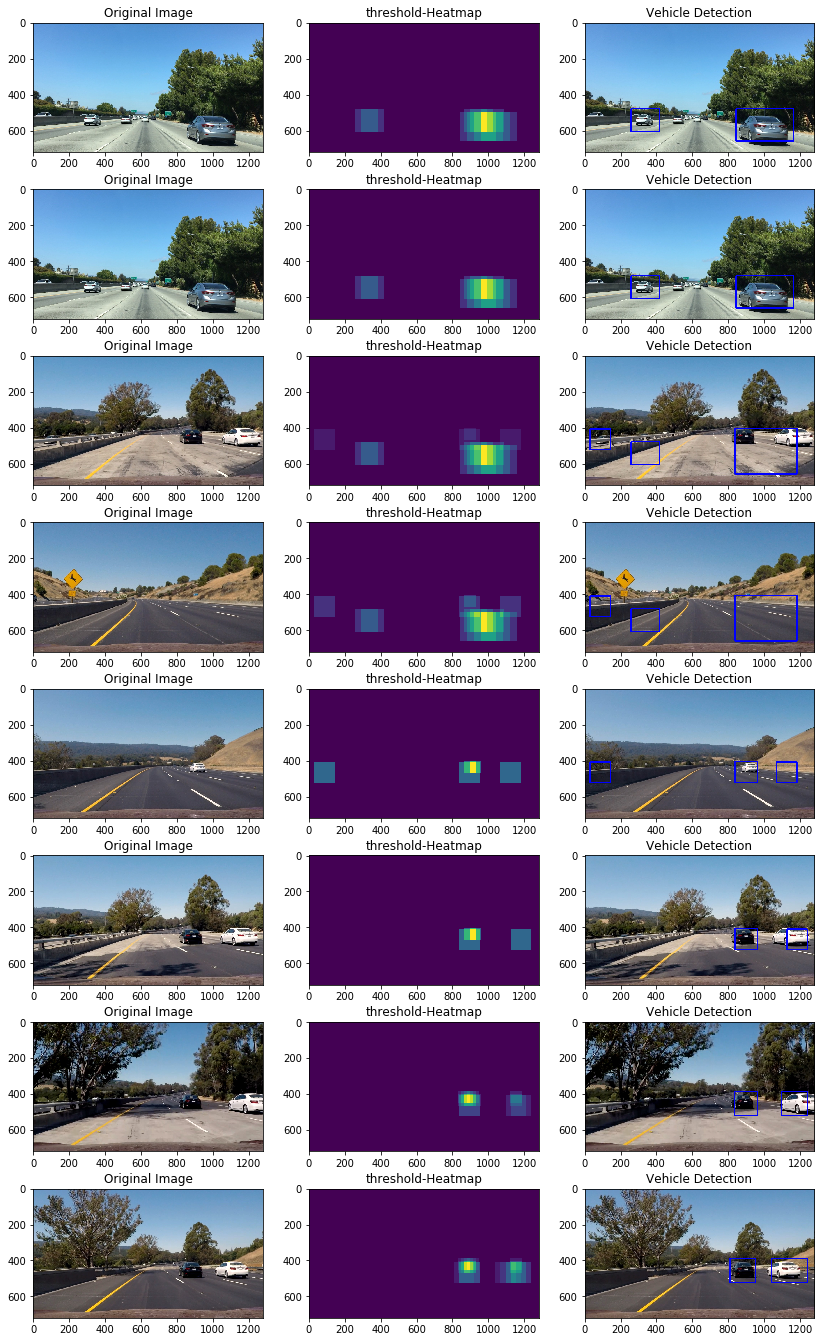

In [36]:
directory = 'test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(14,24))
DV = DetectVehicle(param_dict)

count = 1
for k,img in enumerate(globDir):
    Img = mpimg.imread(img)
    [draw_img,heatmap] = DV.find_cars(Img,vid=False,vis=False)
    
    #fig-1
    fig.add_subplot(8,3,count)
    plt.imshow(Img)
    plt.title('Original Image')
    count += 1
    
    #fig-2
    fig.add_subplot(8,3,count)
    plt.imshow(heatmap)
    plt.title('threshold-Heatmap')
    count += 1
    
    #fig-3
    fig.add_subplot(8,3,count)
    plt.imshow(draw_img)
    plt.title('Vehicle Detection')
    count += 1

--------

-------

### Video Detector

-------

In [36]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
param_dict = {}
param_dict['ystart']  = 400
param_dict['ystop']  = 656
param_dict['scale'] = 1.5
param_dict['svc']  =  dist_pickle["svc"]
param_dict['X_scalar'] = dist_pickle["scaler"]
param_dict['orient'] = dist_pickle["orient"]
param_dict['pix_per_cell'] = dist_pickle["pix_per_cell"]
param_dict['cell_per_block']  = dist_pickle["cell_per_block"]
param_dict['spatial_size'] = (32,32)
param_dict['hist_bins'] = 32
# Read in image similar to one shown above 

DV = DetectVehicle(param_dict)

In [39]:
white_output = 'test_video_output.mp4'
clip = VideoFileClip("test_video.mp4")#.subclip(t_start=30,t_end=35)
white_clip = clip.fl_image(DV.find_cars)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:21<00:00,  1.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 19.3 s, sys: 1.79 s, total: 21.1 s
Wall time: 22.2 s


In [37]:
white_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")#.subclip(t_start=30,t_end=35)
white_clip = clip.fl_image(DV.find_cars)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [10:04<00:00,  1.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 9min 8s, sys: 51.8 s, total: 10min
Wall time: 10min 5s


----------

#### Both lane and vehicle detection

In [38]:
white_output = 'project_video2_output.mp4'
clip = VideoFileClip("project_video2.mp4")#.subclip(t_start=30,t_end=35)
white_clip = clip.fl_image(DV.find_cars)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video2_output.mp4
[MoviePy] Writing video project_video2_output.mp4


100%|█████████▉| 1260/1261 [10:34<00:00,  1.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video2_output.mp4 

CPU times: user 9min 40s, sys: 54.3 s, total: 10min 35s
Wall time: 10min 34s
